<h1>How does the injury rate change with days from the last injury</h1>


In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime as dt, timedelta
from dateutil.relativedelta import *
import re
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import stats
import sqlite3
from joblib import dump, load
pd.set_option('display.max_rows', 500)

<h3>SQLite Handling functions</h3>
<p>Use Pandas to import dataframe into SQLlite</p>

In [2]:
DB = "../assests/hockey_data_goalies.db"

#SQL Handle functions
def run_query(q):
    with sqlite3.connect(DB) as conn:
        x = pd.read_sql(q,conn)
    return x
   
#send command
def run_command(c):
    with sqlite3.connect(DB) as conn:
        conn.isolation_level = None
        return conn.execute(c)
    
#show tables
def show_tables():
    r = """
    Select name,type
    FROM sqlite_master
    WHERE type in ("table","view");
        """
    return run_query(r)

<h2>Import the existing model, excluding players with no injuries (to prevent bias)</h2>

In [3]:
#import data
goalie_data =pd.read_csv('advancedgoaliestats_withadditionalgoalies.csv')
goalie_data.drop(columns=['Unnamed: 0'],inplace=True)
gd_players = goalie_data.groupby('player_id').max()
#get list of players with one reported injury
player_inj_list = gd_players[gd_players['injured']==1].index
goalie_data_inj = pd.DataFrame(columns=goalie_data.columns)
#train model on players from this list
for players in player_inj_list:
    goalie_data_inj = goalie_data_inj.append(goalie_data[goalie_data['player_id']==players].copy())
goalie_data_inj[['rest_days','shots_against','sa3W','pre_inj','injured']] = goalie_data_inj[['rest_days','shots_against','sa3W','pre_inj','injured']].astype(int)
#goalie_data_inj.loc[goalie_data_inj['pre_inj']>=1,'pre_inj'] = 1


In [6]:
goalie_data_inj.reset_index(drop=True,inplace=True)
goalie_data_inj['recent_inj'] = 0
current_id = ''
for row in range(goalie_data_inj.shape[0]):
    #if this is the same player as before, are they returning from an injury?
    if current_id == goalie_data_inj.at[row,'player_id']:
        goalie_data_inj.loc[row,'recent_inj'] = goalie_data_inj.loc[row-1,'injured']
    else:
        current_id = goalie_data_inj.at[row,'player_id']
goalie_data_inj['date_game'] = goalie_data_inj['date_game'].astype('datetime64')

In [48]:
injury_recount = pd.DataFrame(columns=['weeks','injuries','re-injuries'])
for i in range(1,104):
    current_id = ''
    day_span = 7*i
    cnt = 0
    rcnt = 0
    for r in range(goalie_data_inj.shape[0]):
        #if injured have there been previous injuries in the window span?
        if goalie_data_inj.at[r,'injured'] == 1:
            window = (goalie_data_inj['player_id']==goalie_data_inj.loc[r,'player_id'])&(goalie_data_inj.loc[r,'date_game']>=goalie_data_inj['date_game'])&(goalie_data_inj['date_game']>=(goalie_data_inj.loc[r,'date_game']-timedelta(day_span)))
            if goalie_data_inj.loc[window,'player_id'].unique().shape[0]==1:
                cnt += 1
                if goalie_data_inj.loc[window,'recent_inj'].sum()>0:
                    rcnt += 1
    injury_recount = injury_recount.append(dict(zip(injury_recount.columns,[i,cnt,rcnt])),ignore_index=True)

Text(0, 0.5, 'Re-injury Rate')

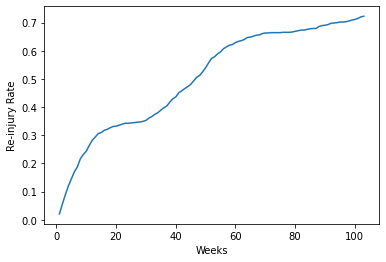

In [49]:
plt.plot(injury_recount['weeks'],injury_recount['re-injuries']/injury_recount['injuries'])
plt.xlabel('Weeks')
plt.ylabel('Re-injury Rate')

In [50]:
injury_recount

,weeks,injuries,re-injuries
0,1,876,18
1,2,876,49
2,3,876,78
3,4,876,105
4,5,876,127
5,6,876,149
6,7,876,164
7,8,876,189
8,9,876,203
9,10,876,213


In [51]:
goalie_data_inj.groupby('player_id').sum()['injured'].value_counts()

1     51
2     26
3     22
4     11
9      9
8      9
13     7
12     6
5      6
6      3
16     3
15     3
14     3
19     2
7      2
18     2
11     2
17     2
10     2
Name: injured, dtype: int64